# **Assignment 3 Report**



# Starter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
a3_path = '/content/drive/MyDrive/Colab Notebooks/ECE421/Assignment 3'

In [ ]:
import sys
sys.path.insert(0,a3_path)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import helper as hlp

# K-means Functions

In [ ]:
@tf.function
def distanceFunc(X, MU):
    X_expand = tf.expand_dims(X,0)
    MU_expand = tf.expand_dims(MU,1)
    distance = tf.reduce_sum(tf.square(tf.subtract(X_expand, MU_expand)),2)
    return tf.transpose(distance)

In [ ]:
def k_means(k): 

  train_loss, val_loss = [], []
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.99, epsilon=1e-5)

  MU = tf.Variable(tf.random.normal([k, dim],dtype=tf.float64))
  
  iteration = 200

  for step in range(iteration):
    with tf.GradientTape() as tape:
      dis = distanceFunc(data,MU)
      loss = tf.reduce_sum(tf.reduce_min(dis,axis = 1))
    gradients = tape.gradient(loss, MU)
    optimizer.apply_gradients([(gradients,MU)])
    train_loss.append(loss.numpy())

    if is_valid:
      dis = distanceFunc(val_data,MU)
      loss = tf.reduce_sum(tf.reduce_min(dis,axis = 1))
      val_loss.append(loss.numpy())
    #   if step % 10 == 9:
    #     print("iteration:", step+1, " training loss:", train_loss[-1], 
    #           " validation loss:", val_loss[-1])
    # else:
    #   if step % 10 == 9:
    #     print("iteration:", step+1, " training loss:", train_loss[-1])

  if is_valid:
    return MU, train_loss, val_loss
  else:
    return MU, train_loss

In [ ]:
def assign_kmeans(X, MU):
  dis = distanceFunc(X, MU)
  return tf.argmin(dis, 1)

# GMM Functions

In [ ]:
@tf.function
def log_GaussPDF(X, MU, SIGMA):
  distance = distanceFunc(X, MU)/tf.transpose(SIGMA)
  out = -0.5*(distance + tf.math.log(tf.transpose(SIGMA)*2*np.pi))
  return out

In [ ]:
@tf.function
def log_posterior(log_PDF, log_pi):
  log_p = log_PDF + tf.transpose(log_pi)
  return log_p - hlp.reduce_logsumexp(log_p, keep_dims=True)

In [ ]:
def GMM(k):

  train_loss, val_loss = [], []
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.99, epsilon=1e-5)

  MU = tf.Variable(tf.random.normal([k, dim],dtype=tf.float64))
  SIGMA = tf.Variable(tf.random.normal([k, 1],dtype=tf.float64))
  PI = tf.Variable(tf.random.normal([k, 1],dtype=tf.float64))
  
  iteration = 500

  for step in range(iteration):

    with tf.GradientTape(persistent=True) as tape:
      SIGMA_constrained = tf.exp(SIGMA)
      PI_constrained = tf.squeeze(hlp.logsoftmax(PI))
      PDF = log_GaussPDF(data, MU, SIGMA_constrained)
      loss = - tf.reduce_sum(hlp.reduce_logsumexp(PDF + PI_constrained, 1, keep_dims=True))

    gradients_MU = tape.gradient(loss, MU)
    gradients_SIGMA = tape.gradient(loss, SIGMA)
    gradients_PI = tape.gradient(loss, PI)
    
    optimizer.apply_gradients([(gradients_MU,MU)])
    optimizer.apply_gradients([(gradients_SIGMA,SIGMA)])
    optimizer.apply_gradients([(gradients_PI,PI)])
    train_loss.append(loss.numpy())

    if is_valid:

      SIGMA_constrained = tf.exp(SIGMA)
      PI_constrained = tf.squeeze(hlp.logsoftmax(PI))
      PDF = log_GaussPDF(val_data, MU, SIGMA_constrained)
      loss = - tf.reduce_sum(hlp.reduce_logsumexp(PDF + PI_constrained, 1, keep_dims=True))
      val_loss.append(loss.numpy())

    #   if step % 10 == 9:
    #     print("iteration:", step+1, " training loss:", train_loss[-1], 
    #           " validation loss:", val_loss[-1])
    # else:
    #   if step % 10 == 9:
    #     print("iteration:", step+1, " training loss:", train_loss[-1])

  if is_valid:
    return (MU, tf.exp(SIGMA), tf.squeeze(hlp.logsoftmax(PI))), train_loss, val_loss
  else:
    return (MU, tf.exp(SIGMA), tf.squeeze(hlp.logsoftmax(PI))), train_loss

In [ ]:
def assign_gmm(X, MU, SIGMA, PI):
  PDF = log_GaussPDF(X, MU, SIGMA)
  return tf.argmax(tf.nn.softmax(log_posterior(PDF, PI)), 1)

# Plot Function

In [ ]:
def plot_loss(t_loss):
  l = len(t_loss)
  plt.plot(range(1,l+1), t_loss, label="Training")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

# Load Data and Train

In [ ]:
is_valid = False

data_file = 'data2D.npy'#'data100D.npy'
data = np.load('{}/{}'.format(a3_path, data_file))
[num_pts, dim] = np.shape(data)

## Train Results for 1.1.1

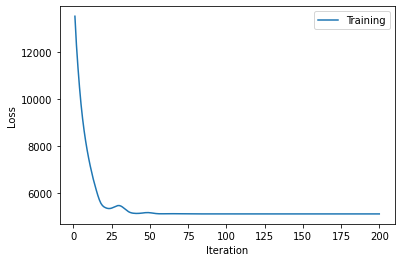

MU
 <tf.Variable 'Variable:0' shape=(3, 2) dtype=float64, numpy=
array([[ 1.25173631,  0.24658667],
       [ 0.12178905, -1.52307679],
       [-1.05590597, -3.24322212]])>


In [ ]:
MU, t_loss = k_means(3)
plot_loss(t_loss)
print('MU\n',MU)

## Train Results for 2.2.1

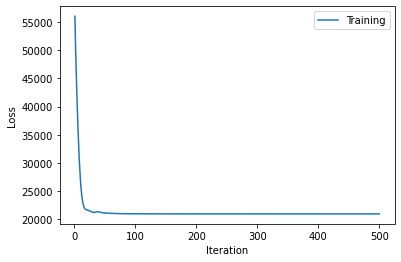

MU
 <tf.Variable 'Variable:0' shape=(3, 2) dtype=float64, numpy=
array([[ 0.07847008, -1.54452655],
       [ 0.07804576, -1.54967153],
       [ 0.10321737, -1.50478627]])>
SIGMA
 tf.Tensor(
[[3.84527941]
 [3.93035515]
 [3.84519834]], shape=(3, 1), dtype=float64)
PI
 tf.Tensor([-6.60058945 -4.17077239 -0.01694261], shape=(3,), dtype=float64)


In [ ]:
(MU, SIGMA, PI), t_loss = GMM(3)
plot_loss(t_loss)
print('MU\n',MU)
print('SIGMA\n',SIGMA)
print('PI\n',PI)

In [ ]:
is_valid = True

data_file = 'data2D.npy'
data = np.load('{}/{}'.format(a3_path, data_file))
[num_pts, dim] = np.shape(data)

if is_valid:
  valid_batch = int(num_pts / 3.0)
  np.random.seed(45689)
  rnd_idx = np.arange(num_pts)
  np.random.shuffle(rnd_idx)
  val_data = data[rnd_idx[:valid_batch]]
  data = data[rnd_idx[valid_batch:]]

## Train Results for 1.1.2

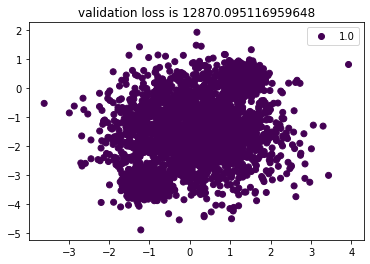

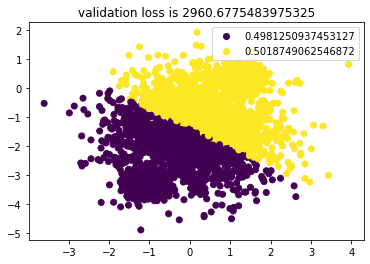

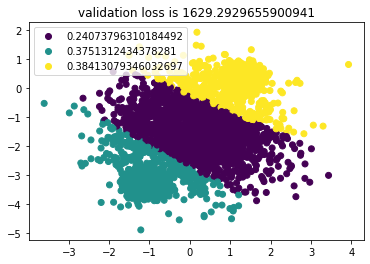

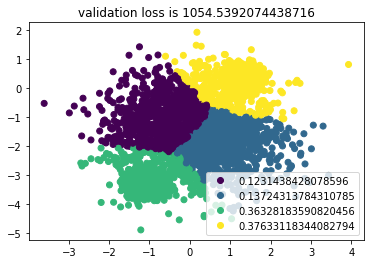

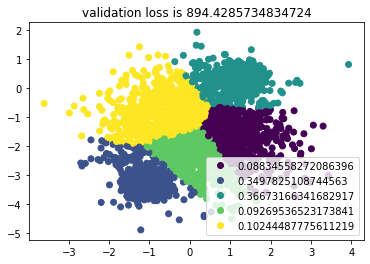

In [ ]:
v_final = []
for k in range(1,6):
  MU, _, v_loss = k_means(k)
  ass = assign_kmeans(data,MU)
  percent = (np.bincount(ass)/len(ass))[np.bincount(ass) != 0]
  scatter = plt.scatter(data[:,0], data[:,1], c = ass)
  plt.legend(scatter.legend_elements()[0], percent)
  plt.title('validation loss is ' + str(v_loss[-1]))
  plt.show()
  v_final.append(v_loss[-1])

## Elbow Plot for 1.1.2

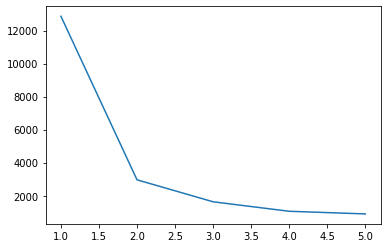

In [ ]:
plt.plot(range(1, len(v_final)+1),v_final)

## Conclusion for 1.1.2

when k > 4, the dataset becomes very unbalanced. Looking at the elbow plot, a k value of 2 seems like turing point for the validation losses. K = 2 is a resonable choice. 

## Train Results for 2.2.2

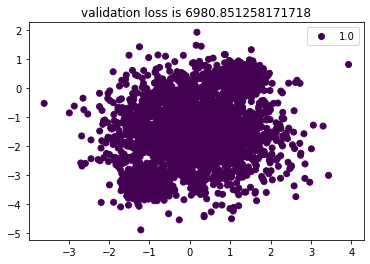

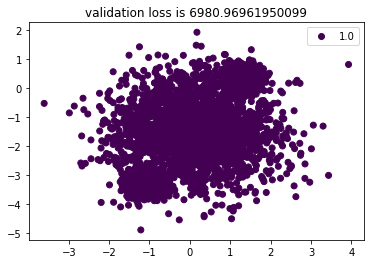

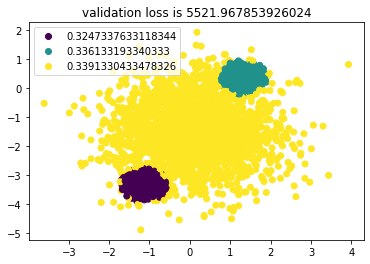

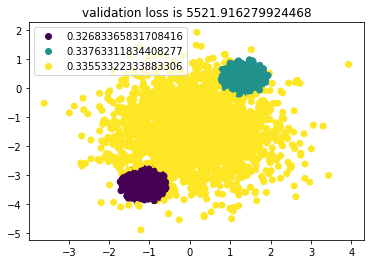

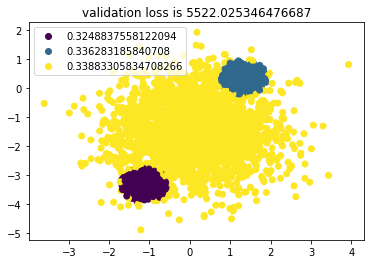

In [ ]:
v_final = []
for k in range(1,6):
  (MU, SIGMA, PI), _, v_loss = GMM(k)
  ass = assign_gmm(data, MU, SIGMA, PI)
  percent = (np.bincount(ass)/len(ass))[np.bincount(ass) != 0]
  scatter = plt.scatter(data[:,0], data[:,1], c = ass)
  plt.legend(scatter.legend_elements()[0], percent)
  plt.title('validation loss is ' + str(v_loss[-1]))
  plt.show()
  v_final.append(v_loss[-1])

## Elbow Plot for 2.1.2

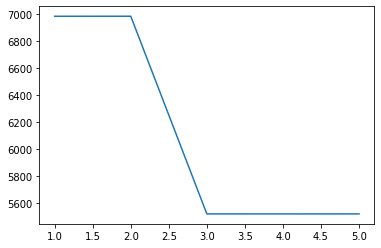

In [ ]:
plt.plot(range(1, len(v_final)+1),v_final)

## Conclusion for 2.1.2

The validation loss did not improve after k = 3 or before k = 2, therefore k = 3 is a resonable choice.

## Train Results for 1.1.3

In [ ]:
is_valid = True

data_file = 'data100D.npy'
data = np.load('{}/{}'.format(a3_path, data_file))
data = np.float64(data)
[num_pts, dim] = np.shape(data)

if is_valid:
  valid_batch = int(num_pts / 3.0)
  np.random.seed(45689)
  rnd_idx = np.arange(num_pts)
  np.random.shuffle(rnd_idx)
  val_data = data[rnd_idx[:valid_batch]]
  data = data[rnd_idx[valid_batch:]]

In [ ]:
v_final_kmeans = []
v_final_gmm = []
MU_kmeans = []
MU_gmm, SIGMA_gmm, PI_gmm = [], [], []

for k in [5, 10, 15, 20, 30]:

  MU, _, v_loss = k_means(k)
  v_final_kmeans.append(v_loss[-1])
  MU_kmeans.append(MU)
  
  (MU, SIGMA, PI), _, v_loss = GMM(k)
  v_final_gmm.append(v_loss[-1])
  MU_gmm.append(MU)
  SIGMA_gmm.append(SIGMA)
  PI_gmm.append(PI)

## Elbow plot for 2.2.3 K means

In [ ]:
v_final_kmeans

[124459.69451019341,
 121259.97081903121,
 70440.17801818301,
 69795.97699930437,
 69208.4713564662]

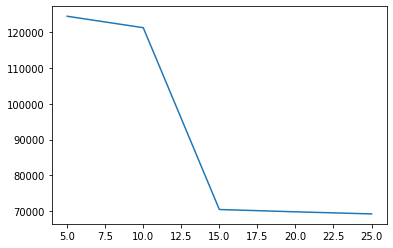

In [ ]:
plt.plot(np.arange(1,6)*5, v_final_kmeans)

## Elbow plot for 2.2.3 MoG

In [ ]:
v_final_gmm

[12399.499485252456,
 12400.317571773376,
 12398.9243834822,
 12400.871162704078,
 12399.827008785232]

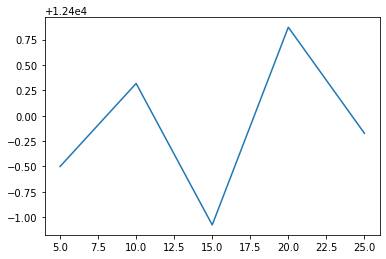

In [ ]:
plt.plot(np.arange(1,6)*5, v_final_gmm)

## Conclusion for 2.2.3

The validation loss for MOG is not improving while for K-means it is steady decreasing.
Therefore we look at the elbow plot for k-means, when is k is between 10 and 15 there seems like a big drop for the validation losses. Therefore the optimal k is between 10 and 15. Also for the same amount of clusters, k means is always perform better than MoG